In [1]:
# This is from Will's tutorial notebook
# It has less helpful text, but can be used, step by step, to produce the yaml, fits, and pickle files for each flight

In [2]:
## First import general packages for running python analysis:
import os, h5py, datetime,pytz,pickle, yaml
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr, concat, drone, bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals.sites import site
import beamcals.reduce_ccclass as rc
gbosite=site.site('../beamcals/beamcals/sites/WLC_config_roof.npz')

In [3]:
#Epols = [0,3,4,7,9,10,12,14]
#Npols = [1,2,5,6,8,11,13,15]

Epols = [0]
Npols = [1]
config_directory="/hirax/GBO_Analysis_Outputs/concat_config_files/"

# dishes are 2n, 2n+1 pairs

In [4]:
###################
#### FUNCTIONS ####
###################

## 1. Find Correspondance between drone flight file and correlator data

In [5]:
dronedir='/hirax/DNS_freespace/yale_visit_april_2025/drone_flight_records/'
flyfile='Apr-12th-2025-03-19PM-Flight-Airdata.csv'
dronedata=drone.Drone_Data(Drone_Directory=dronedir,FLYTAG=flyfile,site_class=gbosite,tlb=0,tub=-1)


Initializing drone data via Airdata.csv routine: Apr-12th-2025-03-19PM-Flight-Airdata.csv
  --> Skipping rows 1 to 499 to eliminate NAN values
  --> generating llh, geocentric cartesian, local cartesian, and local spherical coordinates.
  --> generating dish and receiver line of sight coordinates.


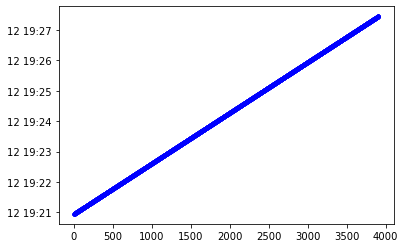

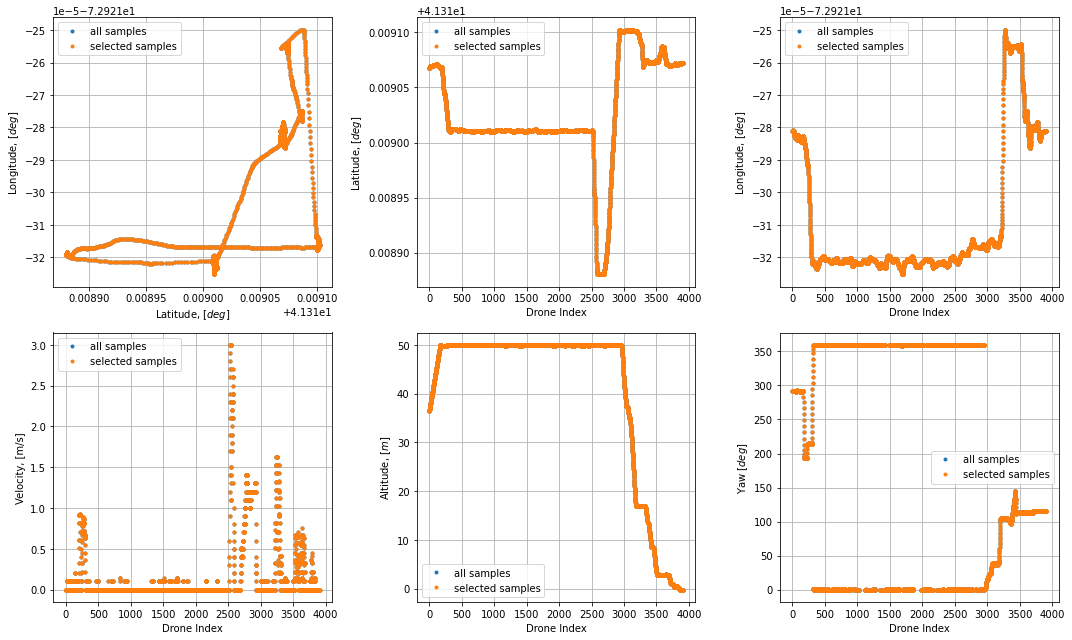

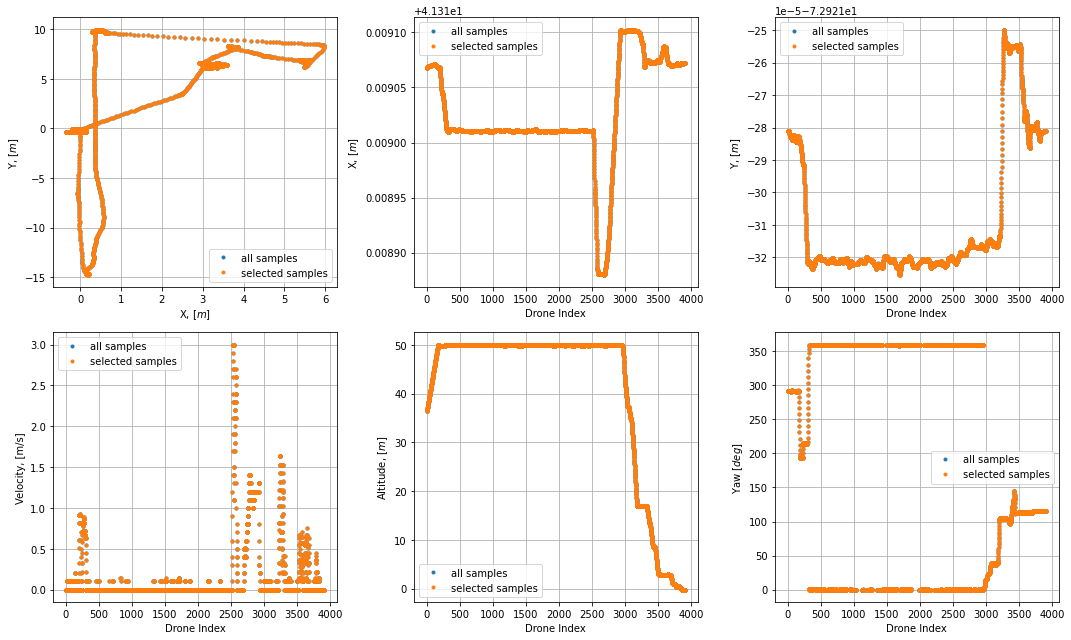

In [6]:
# Plot some drone data to get familiar with the coordinates in the drone class

# Look at time stamps

plt.plot(dronedata.t_arr_datetime,'b.',label='drone')
plt.show()


## Plot lat/long
fig1,[[ax1,ax2,ax3],[ax4,ax5,ax6]]=subplots(nrows=2,ncols=3,figsize=(15,9))
## Plot p0 coordinate origin:
ax1.plot(dronedata.origin[0],dronedata.origin[1],'ro')
ax2.axhline(dronedata.origin[0],c='b')
ax3.axhline(dronedata.origin[1],c='b')
## Title each coordinate subplot:        
ax1.set_title('Lat vs Lon')
ax2.set_title('Lat vs Time')
ax3.set_title('Lon vs Time')
ax4.set_title('Velocity vs Time')
ax5.set_title('Altitude vs Time')
ax6.set_title('Yaw vs Time')
## Specify arrays/vectors to plot in 1,3,4 coordinate subplot
xqtys=[dronedata.latitude,dronedata.t_index,dronedata.t_index,dronedata.t_index,dronedata.t_index,dronedata.t_index]
yqtys=[dronedata.longitude,dronedata.latitude,dronedata.longitude,dronedata.velocity,dronedata.altitude,dronedata.yaw]
xtags=['Latitude, [$deg$]','Drone Index','Drone Index','Drone Index','Drone Index','Drone Index']
ytags=['Longitude, [$deg$]','Latitude, [$deg$]','Longitude, [$deg$]','Velocity, [m/s]','Altitude, [$m$]','Yaw [$deg$]']
for i,ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6]):
    ax.plot(np.nanmin(xqtys[i]),np.nanmin(yqtys[i]))
    ax.plot(np.nanmax(xqtys[i]),np.nanmax(yqtys[i]))
    autoscalelims=ax.axis()
    ax.clear()
    ax.plot(xqtys[i],yqtys[i],'.',label='all samples')
    ax.plot(xqtys[i],yqtys[i],'.',label='selected samples')
    ax.set_xlabel(xtags[i])
    ax.set_ylabel(ytags[i])
    ax.grid()
    ax.legend()
    ax.set_xlim(autoscalelims[0],autoscalelims[1])
    ax.set_ylim(autoscalelims[2],autoscalelims[3])
tight_layout()
plt.show()

## Plot local X/Y coords
fig1,[[ax1,ax2,ax3],[ax4,ax5,ax6]]=subplots(nrows=2,ncols=3,figsize=(15,9))
## Plot p0 coordinate origin:
ax1.set_title('X vs Y')
ax2.set_title('X vs Time')
ax3.set_title('Y vs Time')
ax4.set_title('Velocity vs Time')
ax5.set_title('Altitude vs Time')
ax6.set_title('Yaw vs Time')
## Specify arrays/vectors to plot in 1,3,4 coordinate subplot
xqtys=[dronedata.coords_xyz_LC[:,0],dronedata.t_index,dronedata.t_index,dronedata.t_index,dronedata.t_index,dronedata.t_index]
yqtys=[dronedata.coords_xyz_LC[:,1],dronedata.latitude,dronedata.longitude,dronedata.velocity,dronedata.altitude,dronedata.yaw]
xtags=['X, [$m$]','Drone Index','Drone Index','Drone Index','Drone Index','Drone Index']
ytags=['Y, [$m$]','X, [$m$]','Y, [$m$]','Velocity, [m/s]','Altitude, [$m$]','Yaw [$deg$]']
for i,ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6]):
    ax.plot(np.nanmin(xqtys[i]),np.nanmin(yqtys[i]))
    ax.plot(np.nanmax(xqtys[i]),np.nanmax(yqtys[i]))
    autoscalelims=ax.axis()
    ax.clear()
    ax.plot(xqtys[i],yqtys[i],'.',label='all samples')
    ax.plot(xqtys[i],yqtys[i],'.',label='selected samples')
    ax.set_xlabel(xtags[i])
    ax.set_ylabel(ytags[i])
    ax.grid()
    ax.legend()
    ax.set_xlim(autoscalelims[0],autoscalelims[1])
    ax.set_ylim(autoscalelims[2],autoscalelims[3])
tight_layout()
plt.show()    
    

        

In [7]:
# Load in some correlator data
## Combine drone and correlator data
datadir = '/hirax/DNS_freespace/yale_visit_april_2025/manual_and_0.1_pass/'
gaindir = '/hirax/DNS_freespace/yale_visit_april_2025/manual_and_0.1_pass_digital_gains/'

print('start time: ', datetime.datetime.now())

corrdata=corr.Corr_Data(Data_Directory=datadir,
                            Gain_Directory=gaindir,site_class=gbosite,use_ctime=True,
                            crossmap=[])#,Data_File_Index=np.arange(0,int(fmax)))

    
print('end time: ', datetime.datetime.now())


start time:  2025-06-05 12:41:25.216696
Initializing Correlator Class using:
  --> /hirax/DNS_freespace/yale_visit_april_2025/manual_and_0.1_pass/
  --> Arrays initialized with shape (10, 256, 1024, 2)
Assigning array values by reading in data files:
  --> Loading File: 0017/0139
  --> Finished. Reshaping arrays.
end time:  2025-06-05 12:41:27.274176


[Timestamp('2025-04-12 19:20:56.900000+0000', tz='UTC')
 Timestamp('2025-04-12 19:20:57+0000', tz='UTC')
 Timestamp('2025-04-12 19:20:57.100000+0000', tz='UTC') ...
 Timestamp('2025-04-12 19:27:27.200000+0000', tz='UTC')
 Timestamp('2025-04-12 19:27:27.300000+0000', tz='UTC')
 Timestamp('2025-04-12 19:27:27.300000+0000', tz='UTC')]
[datetime.datetime(2025, 4, 12, 19, 14, 25, 147647, tzinfo=<UTC>)
 datetime.datetime(2025, 4, 12, 19, 14, 25, 189590, tzinfo=<UTC>)
 datetime.datetime(2025, 4, 12, 19, 14, 25, 231533, tzinfo=<UTC>) ...
 datetime.datetime(2025, 4, 12, 19, 17, 27, 557928, tzinfo=<UTC>)
 datetime.datetime(2025, 4, 12, 19, 17, 27, 599871, tzinfo=<UTC>)
 datetime.datetime(2025, 4, 12, 19, 17, 27, 641814, tzinfo=<UTC>)]


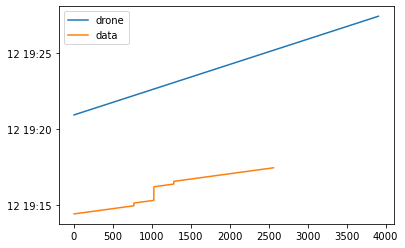

In [8]:
print(dronedata.t_arr_datetime)
print(corrdata.t_arr_datetime)

# Find time correspondance
plot(dronedata.t_arr_datetime,label='drone')
plot(corrdata.t_arr_datetime,label='data')
legend()

## 1. Fitting time offsets, background, writing yamls and Gaussian values

In [ ]:
f = -1
with open('/hirax/GBO_Analysis_Outputs/DNS_WL_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]

for fi in range(0,len(documents["flight_info"]["flights"])):
    if fly == flights[fi]: f = fi
print(f, 'FLIGHT: ', documents["flight_info"]["flights"][f])

fly = flights[f]
tub = documents["flight_info"]["tubs"][f]
tlb = documents["flight_info"]["tlbs"][f]
cdat = documents["flight_info"]["cdats"][f]
tclb = documents["flight_info"]["tclbs"][f]
tcub = documents["flight_info"]["tcubs"][f]
fmax = documents["flight_info"]["fmaxes"][f]


In [ ]:
if int(fly) < 537:
    mdir='/hirax/GBO_Aug_2021/TONE_ACQ/'+cdat+'_yale_drone/corr/' # August 2021
    gaindir='/hirax/GBO_Aug_2021/TONE_ACQ/digital_gains/'+cdat+'_yale_drone_yale_digitalgain/' # August 2021
else:
    mdir='/hirax/GBO_Oct_2021/TONE_ACQ/'+cdat+'_yale_drone/corr/' # Oct 2021
    gaindir='/hirax/GBO_Oct_2021/TONE_ACQ/digital_gains/'+cdat+'_yale_drone_yale_digitalgain/' # Oct 2021

sdir = os.listdir(mdir)[0]
datadir=mdir+sdir+'/'
print(sdir, datadir,gaindir)
    
dronedir='/hirax/all_drone_data/datcon_csv/'
dronetest0825=drone.Drone_Data(Drone_Directory=dronedir,FLYTAG='FLY'+fly+'.csv',site_class=gbosite,tlb=tlb,tub=tub)

print('DONE reading in drone data')
print(dronetest0825.t_arr_datetime[0], dronetest0825.t_arr_datetime[-1])


In [ ]:
plt.plot(dronetest0825.t_arr_datetime,'b.',label='drone')
plt.show()

pu.Plot_Drone_Coordinates(dronetest0825,coo='xy')#,t_bounds=[tlb,tub])
#pu.Plot_Drone_Coordinates(dronetest0825,coo='xy',t_bounds=[tlb,tub])

In [ ]:
## Combine drone and correlator data
print('start time: ', datetime.datetime.now())
if str(fmax) != 'None':# 
    corrtest0825=corr.Corr_Data(Data_Directory=datadir,
                            Gain_Directory=gaindir,site_class=gbosite,
                            crossmap=[],Data_File_Index=np.arange(0,int(fmax)))
else:
    corrtest0825=corr.Corr_Data(Data_Directory=datadir,
                            Gain_Directory=gaindir,site_class=gbosite,
                            crossmap=[])
#

    
print('end time: ', datetime.datetime.now())

# putting checks in one cell now that I know I've mostly figured out the flight/corr file correspondence
# This checks I copied and pasted ok :)

## plot their datetime arrays to check overlap:

plot(dronetest0825.t_arr_datetime,label='drone')
plot(corrtest0825.t_arr_datetime,label='data')
legend()


In [ ]:
# Match drone and correlator data together, and plot a few frequencies

config_directory="/hirax/GBO_Analysis_Outputs/concat_config_files/"

concattest0825=concat.CONCAT(CORRDATCLASS=corrtest0825,DRONEDATCLASS=dronetest0825,\
                             load_yaml=False,traceback=True,save_traceback=True)
#concattest0825=concat.CONCAT(CORRDATCLASS=corrtest0825,DRONEDATCLASS=dronetest0825,load_yaml=True,
#                             traceback=False,save_traceback=False)

pu.Plot_Time_Series(concattest0825,freqlist=[200,400,832,900]) # previously set to just 700

In [ ]:
# This is for invesigating wierdness in a particular flight, eg 648 has a lot of zeros due to gain settings
pu.Plot_Waterfalls(concattest0825)
#
# lets get the minimum along the time axis, channel 0 is fine
#print(concattest0825.V.shape) # time, freq,chan
#
#mins = np.zeros(1024)
#for f in np.arange(0,1024):
#    mins[f] = np.min(concattest0825.V[:,f,0])
#    
#freqs = np.arange(800,400,-400./1024)
#plt.plot(freqs,mins)
#plt.xlim(400,600)
#plt.ylim(0,1E-9)
#plt.show()
#
#bf = np.where(mins==0.0)[0]
#print(len(bf),bf)

In [ ]:
## Let's find the time bounds for a central transit, and examine those bounds when we solve for the source pulses:

find=900
fig=figure(figsize=(16,8))
for i in range(concattest0825.n_channels)[:2]:
    ax1=fig.add_subplot(2,2,i+1)
    ax2=fig.add_subplot(2,2,i+3)
    ax1.semilogy(concattest0825.t_index[:],concattest0825.V[:,find,concattest0825.chmap[i]],'.')
    for ax in [ax1,ax2]:
        ax.semilogy(concattest0825.t_index[tclb:tcub],concattest0825.V[tclb:tcub,find,concattest0825.chmap[i]],'.')
ax1.set_xlim(tclb,tcub)
ax2.set_xlim(tclb,tcub)

## So we've identified time bounds where we can see the pulsing source transit!
    ## Infact, I think we are seeing a sidelobe on channel 1!
    ## Let's see if we can extract the on/off indices...

In [ ]:
print(tclb,tcub)

In [ ]:
## OBJECTIVE 5A: concat Function: Extract_Source_Pulses

## Let's use the Extract_Source_Pulses function:
    # The Period and Dutycycle options are known beforehand, and given in microseconds.
    # The t_bounds option just determines the plot bounds, not the solving routine.
## Fortunately, these parameters are loaded from the config, so we don't have to wait for the solver to run.
    ## The returned t_delta_pulse parameter will be given in seconds.
    ## In the verification plot, we should see the following points plotted:
        # orange_o = inds_off  = times when the source is off
        # blue_o   = inds_on   = times when the source is on and broadcasting
        # green_x  = inds_span = times where the behavior changes during the integration period (omit always!)
    ## The print statements shows the list of indices that appear in more than one of on/off/span.
        ## If they are all empty lists [], then there is no overlap which is a good thing.


print('start time: ', datetime.datetime.now())
concattest0825.Extract_Source_Pulses(Period=0.4e6,Dutycycle=0.2e6,t_bounds=[tclb+2500,tcub-2500])
#concattest0825.Extract_Source_Pulses(Period=400000,Dutycycle=200000,t_bounds=[tclb,tcub],f_ind=900)

print('end time: ', datetime.datetime.now())

In [ ]:
# aside to look at the span, on, and off indices in more detail
find=900
chind = 1
t_cut = concattest0825.inds_on
t_span = concattest0825.inds_span
t_off = concattest0825.inds_off
N = len(t_cut)
N2 = int(N/2)
print(len(t_cut),len(t_span),len(t_off))
plt.figure(1,figsize=(10,10))

plt.plot(concattest0825.t_arr_datetime[t_cut],concattest0825.V[t_cut,find,chind],'b.',label='on')
plt.plot(concattest0825.t_arr_datetime[t_span],concattest0825.V[t_span,find,chind],'gx',label='span')
plt.plot(concattest0825.t_arr_datetime[t_off],concattest0825.V[t_off,find,chind],'r.',label='off')
plt.xlim(concattest0825.t_arr_datetime[t_cut[N2]],concattest0825.t_arr_datetime[t_cut[N2+300]])
plt.legend()
plt.show()

In [ ]:
f=900
p = 0
plt.scatter(concattest0825.drone_xyz_LC_interp[t_cut,0],concattest0825.drone_xyz_LC_interp[t_cut,1],
            c=10*np.log10(concattest0825.V[t_cut,f,p]),s=10.0,
            cmap='gnuplot2')
#plt.xlim(-40,40)
#plt.ylim(-40,40)
plt.colorbar()
plt.show()

In [ ]:
## OBJECTIVE 5B: concat Function: Perform_Background_Subtraction

## Let's do background subtraction: creates computed background (V_bg) and background-subtracted (V_bgsub) arrays:
    # window_size=5 - this is 1/2 the width of the 'index window' across which the background is averaged.
    # This function only works if the source was pulsed and Extract_Source_Pulses was used!
concattest0825.Perform_Background_Subtraction(window_size=5)

In [ ]:
p=1
plt.scatter(concattest0825.drone_xyz_LC_interp[t_cut,0],concattest0825.drone_xyz_LC_interp[t_cut,1],
            c=10*np.log10(concattest0825.V_bgsub[t_cut,f,p]),s=10.0,
            cmap='gnuplot2')
#plt.xlim(-40,40)
#plt.ylim(-40,40)
plt.colorbar()
plt.show()

In [ ]:
## OBJECTIVE 5C: concat Function: Synchronization_Function

## This function finds the absolute timing shift between the dji data from the drone and the correlator
    ## We will be loading t_delta_dji from the config file to save some time!
    ## This function only works if the source was pulsed and if V_bgsub was created using background subtraction.
    ## This function works by zooming into the gaussian main beam and removing saturated data points...
## To run, you must give the following:
    ## inputcorr  = the corr class used in the concat
    ## inputdrone = the drone class used in the concat
## The optional parameters and their default values are listed below:
    ## coarse_params=[-10.0,10.0,0.2]    = the min,max,step parameters for the coarse time offset array
    ## fine_params=[-0.5,0.5,0.01]       = the min,max,step parameters for the fine time offset array
    ## chans=np.arange(0,2)              = the channels to fit. 0,1 gives us each polarization
    ## freqs=np.arange(100,1024,150)     = the min,max,step parameters for the freq array axis
    ## FMB_coordbounds=[50.0,50.0,150.0] = the cartesian coords we restrict around the main beam
        # x within +/- 50m from dish center in Local Cartesian (LC)
        # y within +/- 50m from dish center in Local Cartesian (LC)
        # z > 150m from dish center in Local Cartesian (LC)
    ## FMB_ampbound=0.999                = amplitude percentile threshold for saturation... 
        # time indices where the amplitude exceeds 0.999*maximum value are excluded because they are saturated

concattest0825.Synchronization_Function(inputcorr=corrtest0825,inputdrone=dronetest0825,
                                        coarse_params=[-5.0,5.0,0.2],
                                        FMB_coordbounds=[30.0,30.0,150.0],
                                        FMB_ampbound=0.999)

## Since we are loading from the config, we get to skip an iterative loop and just take the solution and apply it.
    ## The verification plot shown is hidden when traceback==False is set in the concat initialization
    ## Look closely at the verification plots to see which channel appears to be the co-pol (channel 1)
    ## In the bottom 2 panels, compare the fit result (white gaussian) to the data points (in color)
        ## We are omitting the saturated points to find the REAL max value, instead of squashing our peak
        ## If we are satisfied with this fit, we should try to save the parameters we found...

In [ ]:
plt.scatter(concattest0825.drone_xyz_LC_interp[t_cut,0],concattest0825.drone_xyz_LC_interp[t_cut,1],
            c=10*np.log10(concattest0825.V_bgsub[t_cut,f,p]),s=10.0,
            cmap='gnuplot2')
#plt.xlim(-40,40)
#plt.ylim(-40,40)
plt.colorbar()
plt.show()

In [ ]:
concattest0825.Distance_Compensation(f_ind=900,plot_channels=[0])

In [ ]:
## OBJECTIVE 5D: concat Function: Export_yaml

## When we have results we want to save, we should export our results to a config file for future use:
    ## The file will be written to the directory stated when the concat class was initialized.
    ## If a concat config yaml file already exists, a new version will be saved.
## Uncomment this if you want to export a config file... 
concattest0825.Export_yaml()

In [ ]:
p=1
f = 896#768#896#832

for f in np.arange(512,1024,100):
    print(f)
    plt.scatter(concattest0825.drone_xyz_LC_interp[:,0],concattest0825.drone_xyz_LC_interp[:,1],
            c=10*np.log10(concattest0825.V[:,f,p]),s=10.0,
            cmap='gnuplot2')
    #plt.xlim(-40,40)
    #plt.ylim(-40,40)
    plt.colorbar()
    plt.show()

#plt.hist(concattest0825.V[:,f,p],range=[-1E-11,1E-11],bins=100)
#plt.show()

In [ ]:
## OBJECTIVE 5E: concat Function: Main_Beam_Fitting

## Now we can do some analysis, since we have synchronized useful data. We can begin by fitting the main beam:
    ## You can specify the directory where you want the fit params to be output:
    ## fit_param_directory='/hirax/GBO_Analysis_Outputs/main_beam_fits/'
    ## This one sometimes takes a while, feel free to get a coffee or something.
concattest0825.Main_Beam_Fitting(fit_param_directory='/hirax/GBO_Analysis_Outputs/main_beam_fits/',
                                 FMB_ampbound=0.999,
                                 Vargs='bgsub')

In [ ]:
# copy and paste the file list above to make a plot
## this is your first glance at whether the Gaussian fits make sense across frequency for all channels
## these are grouped by polarization: small dots are one pol, big dots are the other
filelist=['FLY648_20211022T191922Z_ver_20231012T160758_2dGauss_and_Airy_Params.npz']
pu.plot_MBG_fits(filelist,cmp='gnuplot2')

In [ ]:
print(fits['G_popt'].shape)

In [ ]:
markers = ['s','v','^','>','P','x','+','o']
colors=['red','orange','yellow','green','blue','purple','pink']
import glob

fits = np.load('/hirax/GBO_Analysis_Outputs/main_beam_fits/FLY648_20211022T191922Z_ver_20231012T160758_2dGauss_and_Airy_Params.npz')
pols=[0,2,8,10,14]
freqs = np.arange(800,400,-400/1024)

# amp
fig = plt.figure(figsize=(8,6))
for pp,p in enumerate(pols):
    plt.plot(freqs,fits['G_popt'][p,:,0],markersize=4,color=colors[pp],label=str(p))
plt.title('Amplitude')
plt.legend()
plt.ylim(0,1.5E-7)
plt.show()

# X width
fig = plt.figure(figsize=(8,6))
for pp,p in enumerate(pols):
    plt.plot(freqs,fits['G_popt'][p,:,2],markersize=4,marker='.',color=colors[pp],linestyle='None',label=str(p))
plt.title('X width')
plt.legend()
plt.ylim(4,15)
plt.show()

# Y width
fig = plt.figure(figsize=(8,6))
for pp,p in enumerate(pols):
    plt.plot(freqs,fits['G_popt'][p,:,4],markersize=4,marker='.',linestyle='None',color=colors[pp],label=str(p))
plt.title('Y width')
plt.legend()
plt.ylim(4,17)
plt.show()

# X center
fig = plt.figure(figsize=(8,6))
for pp,p in enumerate(pols):
    plt.plot(freqs,fits['G_popt'][p,:,1],markersize=4,color=colors[pp],label=str(p))
plt.title('X center')
plt.legend()
#plt.ylim(4,14)
plt.show()

# Y center
fig = plt.figure(figsize=(8,6))
for pp,p in enumerate(pols):
    plt.plot(freqs,fits['G_popt'][p,:,3],markersize=4,color=colors[pp],label=str(p))
plt.title('Y center')
plt.legend()
#plt.ylim(4,14)
plt.show()


In [ ]:
# write out to a pickle file, name is autogenerated in the Smallify class

thingy = rc.Smallify(concattest0825)
print(thingy.tmppath)
with open(thingy.tmppath, 'wb') as outp:
    pickle.dump(thingy, outp, pickle.HIGHEST_PROTOCOL)
print('DONE')

In [ ]:
radfile = '/hirax/GBO_Analysis_Outputs/FLY625_20210826T182904Z_ver_20230905T125440_concat.pkl'
radfile = thingy.tmppath
print('Loading: ',radfile)
with open(radfile, 'rb') as inp:
    ptest = pickle.load(inp)



In [ ]:

plt.scatter(ptest.drone_xyz_LC_interp[:,0],ptest.drone_xyz_LC_interp[:,1],c=10*np.log10(ptest.V_bgsub[:,900,p]), cmap='gnuplot2')

In [ ]:
print(len(ptest.V_bgsub[:,0,0]),len(ptest.V_bgsub[0,:,0]),len(ptest.V_bgsub[0,0,:]))
print(len(ptest.V_bg[:,0,0]),len(ptest.V_bg[0,:,0]),len(ptest.V_bg[0,0,:]))

In [ ]:
## let's try some operations to save it

# write a reduced class
[a for a in dir(ptest) if not a.startswith('__')] # prints out all attrs

In [ ]:
################################################
################# DEPRECATED ###################
################################################
##### Below is deprcated, keep as a record #####
################################################
################# DEPRECATED ###################
################################################
#
## Checking if the flight and numbers correspond from what I've written in the spreadsheet#
#
## 1. You will want to exclude regions of the flight that contain the drone moving to/from home.
### a. read the whole file in (tlb, tub to 0,-1)
### b. read in the flight
### c. plot (I suggest in a separate cell) the flight, examine with various tlb, tub bounds until you've 
###    excluded the stuff you don't want
### d. copy the tlb, tub into a vector under the flight for posterity [someday, a yaml, but not today]
### e. read in the drone file again, this time setting the tlb, tub to something
### this last step is crucial, there isn't a better way to restrict the rest of the analysis/pickling afterwards
#
#[tlb,tub]=[0,-1] # default values to read in full array
#
#config_directory="/hirax/GBO_Analysis_Outputs/concat_config_files/"
#tclb,tcub=[8500,20000]
#
#
##fly = '533'
##cdat= '20210826T182904Z'
##[tlb,tub]=[1900,11000]
#
##fly = '534'
##cdat = '20210826T185621Z'
##[tlb,tub]=[1650,10000]
#
##fly = '535'
##cdat = '20210826T192056Z'
##[tlb,tub]=[2000,9500]
#
##fly = '536' # this flight, careful to read in only corr files 0-95
##cdat = '20210826T195003Z'
##[tlb,tub]=[1600,10100]
#
##fly='613'
##cdat='20211021T144905Z'
##[tlb,tub]=[5300,13800]
#
##fly = '615'
##cdat = '20211021T151650Z'
##[tlb,tub]=[3200,10600]
#
##fly = '618'
##cdat = '20211021T183430Z'
##[tlb,tub]=[7300,15000]
#
##fly = '619'
##cdat = '20211021T185805Z'
##[tlb,tub]=[3000,11400]
#
##fly = '620'
##cdat = '20211021T192212Z'
##[tlb,tub]=[1550,9400]
#
##fly = '623'
##cdat = '20211021T203206Z'
##[tlb,tub]=[1700,9500]
#
##fly = '624'
##cdat = '20211021T205659Z'
##[tlb,tub]=[2400,10200]
#
##fly = '625'
##cdat = '20211021T214028Z'
##[tlb,tub]=[2900,12000]
#
##fly = '646'
##cdat = '20211022T183659Z'
##[tlb,tub]=[7500,16100]
#
##fly = '647'
##cdat = '20211022T185749Z'
##[tlb,tub]= [1600,10400]
#
##fly = '648'
##cdat = '20211022T191922Z'
##[tlb,tub]=[2700,10700]
#
##fly = '649'
##cdat = '20211022T194308Z'
##[tlb,tub]=[1500,9900]
#
#if int(fly) < 537:
#    mdir='/hirax/GBO_Aug_2021/TONE_ACQ/'+cdat+'_yale_drone/corr/' # August 2021
#    gaindir='/hirax/GBO_Aug_2021/TONE_ACQ/digital_gains/'+cdat+'_yale_drone_yale_digitalgain/' # August 2021
#else:
#    mdir='/hirax/GBO_Oct_2021/TONE_ACQ/'+cdat+'_yale_drone/corr/' # Oct 2021
#    gaindir='/hirax/GBO_Oct_2021/TONE_ACQ/digital_gains/'+cdat+'_yale_drone_yale_digitalgain/' # Oct 2021
#
#sdir = os.listdir(mdir)[0]
#datadir=mdir+sdir+'/'
#print(sdir, datadir,gaindir)
#    
#dronedir='/hirax/all_drone_data/datcon_csv/'
#dronetest0825=drone.Drone_Data(Drone_Directory=dronedir,FLYTAG='FLY'+fly+'.csv',site_class=gbosite,tlb=tlb,tub=tub)
#
#print('DONE reading in drone data')
#print(dronetest0825.t_arr_datetime[0], dronetest0825.t_arr_datetime[-1])
#
################################################
################# DEPRECATED ###################
################################################
##### Above is deprcated, keep as a record #####
################################################
################# DEPRECATED ###################
################################################
